In [1]:
import pandas as pd
import os
import numpy as np
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Constants
DATASET_PATH = 'D:\\Descargas\\genres_lat'
NUM_SAMPLES = 300
DURATION = 10
NUM_GENRES = 5
SAMPLE_RATE = 22050
NUM_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512

In [3]:
def load_data(dataset_path):
    data = {
        'label': [],
        'path': []
    }
    for genre in os.listdir(dataset_path):
        genre_path = os.path.join(dataset_path, genre)
        for file in os.listdir(genre_path)[:NUM_SAMPLES]:
            data['label'].append(genre)
            data['path'].append(os.path.join(genre_path, file))
    return pd.DataFrame(data)

In [4]:
def extract_features(file_path):
    audio, _ = librosa.load(file_path, duration=DURATION, sr=SAMPLE_RATE, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=NUM_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    return mfccs.T

In [5]:
def prepare_dataset(df):
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        features = extract_features(row['path'])
        X.append(features)
        y.append(row['label'])
    return np.array(X), np.array(y)

In [6]:
# Load and prepare data
df = load_data(DATASET_PATH)
X, y = prepare_dataset(df)

100%|██████████| 1500/1500 [01:30<00:00, 16.58it/s]


In [ ]:
load_data['label'].value_counts()

In [7]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [9]:
# Build the model
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(3),
    Conv1D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(3),
    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_GENRES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


In [11]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
38/38 [==============================] - 7s 138ms/step - loss: 2.1087 - accuracy: 0.4414 - val_loss: 4.7281 - val_accuracy: 0.2267
Epoch 2/100
38/38 [==============================] - 2s 59ms/step - loss: 0.7682 - accuracy: 0.7202 - val_loss: 2.2328 - val_accuracy: 0.3700
Epoch 3/100
38/38 [==============================] - 2s 58ms/step - loss: 0.4973 - accuracy: 0.8159 - val_loss: 1.6324 - val_accuracy: 0.4600
Epoch 4/100
38/38 [==============================] - 2s 51ms/step - loss: 0.2927 - accuracy: 0.9152 - val_loss: 0.9508 - val_accuracy: 0.6900
Epoch 5/100
38/38 [==============================] - 2s 60ms/step - loss: 0.2586 - accuracy: 0.9099 - val_loss: 0.7332 - val_accuracy: 0.7567
Epoch 6/100
38/38 [==============================] - 2s 55ms/step - loss: 0.1860 - accuracy: 0.9364 - val_loss: 0.6543 - val_accuracy: 0.7733
Epoch 7/100
38/38 [==============================] - 2s 52ms/step - loss: 0.1146 - accuracy: 0.9562 - val_loss: 0.5384 - val_accuracy: 0.8433
Epoch

In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

10/10 [==============================] - 0s 13ms/step - loss: 0.4749 - accuracy: 0.8667
Test accuracy: 0.8667


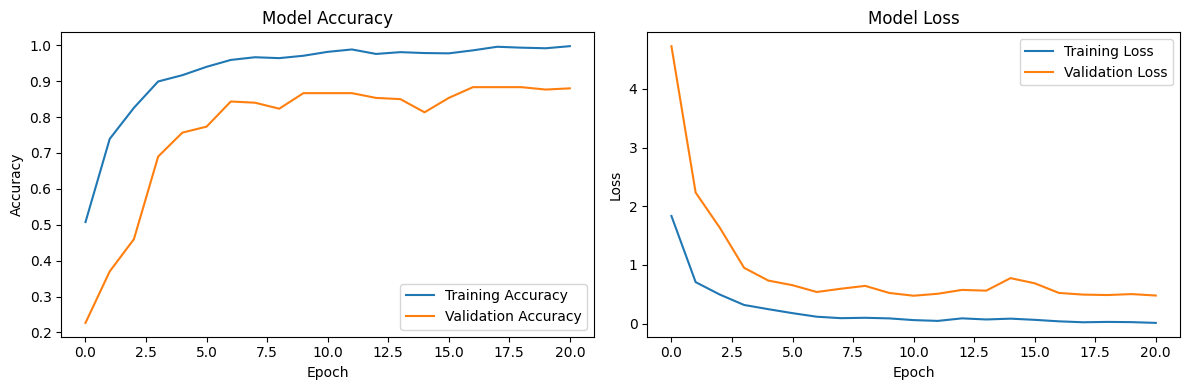

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Save the model
model.save("latin_music_genre_classifier.h5")
print("Model saved successfully.")

Model saved successfully.
